# EpiCoV EDA for Jan-Apr 2020

In [1]:
# General
import os
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Geospatial libraries
import pycountry # to standardize country names
import difflib # to get close matches for country names
import pycountry_convert as pc # to convert country names to ISO codes

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../../data/jan20_apr20.tsv", sep="\t")
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Virus name                       9408 non-null   object 
 1   Accession ID                     9408 non-null   object 
 2   Collection date                  9408 non-null   object 
 3   Location                         9408 non-null   object 
 4   Host                             9408 non-null   object 
 5   Additional location information  575 non-null    object 
 6   Sampling strategy                0 non-null      float64
 7   Gender                           9408 non-null   object 
 8   Patient age                      9405 non-null   object 
 9   Patient status                   9393 non-null   object 
 10  Last vaccinated                  0 non-null      float64
 11  Passage                          9408 non-null   object 
 12  Specimen            

((9408, 17), None)

In [3]:
df1 = pd.read_csv("../../data/locs_jan20_apr20.tsv", sep="\t")
df1.shape, df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Accession ID     9408 non-null   object
 1   Collection date  9408 non-null   object
 2   Submission date  9408 non-null   object
 3   Location         9408 non-null   object
dtypes: object(4)
memory usage: 294.1+ KB


((9408, 4), None)

In [4]:
df = pd.merge(df, df1, on="Accession ID", how="left").drop(columns=["Collection date_x", "Location_x"])
df.rename(columns={"Collection date_y": "Collection date", "Location_y": "Location"}, inplace=True)
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Virus name                       9408 non-null   object 
 1   Accession ID                     9408 non-null   object 
 2   Host                             9408 non-null   object 
 3   Additional location information  575 non-null    object 
 4   Sampling strategy                0 non-null      float64
 5   Gender                           9408 non-null   object 
 6   Patient age                      9405 non-null   object 
 7   Patient status                   9393 non-null   object 
 8   Last vaccinated                  0 non-null      float64
 9   Passage                          9408 non-null   object 
 10  Specimen                         3122 non-null   object 
 11  Additional host information      293 non-null    object 
 12  Lineage             

((9408, 18), None)

In [5]:
df["Submission date"] = pd.to_datetime(df["Submission date"], format="mixed")
df["Submission date"].min(), df["Submission date"].max()

(Timestamp('2020-01-10 00:00:00'), Timestamp('2020-04-14 00:00:00'))

In [6]:
df["Collection date"] = pd.to_datetime(df["Collection date"], format="mixed")
df["Collection date"].min(), df["Collection date"].max()

(Timestamp('2013-07-24 00:00:00'), Timestamp('2020-04-10 00:00:00'))

Find average time between collection of sample and submission of entry

In [7]:
df["collection_to_submission_days"] = (df["Submission date"] - df["Collection date"]).dt.days / (365.25 / 12)  # Convert to months
df["collection_to_submission_days"].describe()

count    9408.000000
mean        0.693637
std         1.306213
min         0.000000
25%         0.427105
50%         0.558522
75%         0.788501
max        78.028747
Name: collection_to_submission_days, dtype: float64

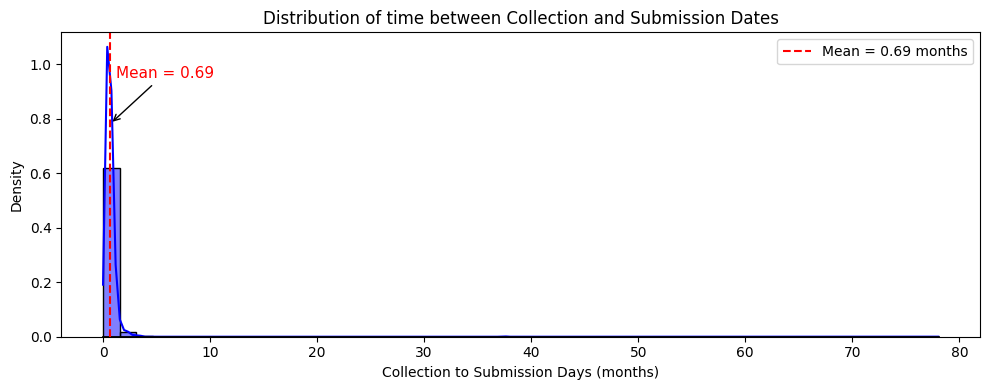

In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(df["collection_to_submission_days"], bins=50, kde=True, color='blue', stat='density')
sns.lineplot(x=sorted(df["collection_to_submission_days"]), 
             y=np.full(df.shape[0], 0), color='black', linewidth=2)
mean_days = df["collection_to_submission_days"].mean()
plt.axvline(mean_days, color='red', linestyle='--', label=f"Mean = {mean_days:.2f} months")

# Place annotation above the mean line, at the top of the plot
ymax = plt.gca().get_ylim()[1]
plt.annotate(f"Mean = {mean_days:.2f}", xy=(mean_days, ymax*0.7), xytext=(mean_days+0.5, ymax*0.85),
             arrowprops=dict(facecolor='red', arrowstyle='->'), color='red', fontsize=11)

plt.xlabel("Collection to Submission Days (months)")
plt.title("Distribution of time between Collection and Submission Dates")
plt.legend()
plt.tight_layout()
plt.show()

Georgraphic heatmaps: [here](https://www.relataly.com/visualize-covid-19-data-on-a-geographic-heat-maps/291/)
Let's see which continents have contributed to this data

In [9]:
set([x.split("/")[0] for x in df["Location"].values.tolist()])

{'Africa ', 'Asia ', 'Europe ', 'North America ', 'Oceania ', 'South America '}

Collate required columns

In [10]:
df1 = df[["Virus name", "Accession ID", "Location", "Collection date", "Gender", "Patient age", "Patient status","Specimen"]]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Virus name       9408 non-null   object        
 1   Accession ID     9408 non-null   object        
 2   Location         9408 non-null   object        
 3   Collection date  9408 non-null   datetime64[ns]
 4   Gender           9408 non-null   object        
 5   Patient age      9405 non-null   object        
 6   Patient status   9393 non-null   object        
 7   Specimen         3122 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 588.1+ KB


Split location into `continent`, `country`, `state` and `city`

In [11]:
df1["continent"], df1["country"], df1["state"], df1["city"] = np.nan, np.nan, np.nan, np.nan

cols = ["continent", "country", "state", "city"]
for i, row in df1.iterrows():
    loc = row["Location"]
    locs = [x.strip() for x in loc.split("/")]
    for j in range(min(len(locs),len(cols))):
        df1.loc[i, cols[j]] = locs[j]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Virus name       9408 non-null   object        
 1   Accession ID     9408 non-null   object        
 2   Location         9408 non-null   object        
 3   Collection date  9408 non-null   datetime64[ns]
 4   Gender           9408 non-null   object        
 5   Patient age      9405 non-null   object        
 6   Patient status   9393 non-null   object        
 7   Specimen         3122 non-null   object        
 8   continent        9408 non-null   object        
 9   country          9408 non-null   object        
 10  state            8409 non-null   object        
 11  city             1505 non-null   object        
dtypes: datetime64[ns](1), object(11)
memory usage: 882.1+ KB


## Entries distribution countrywise

We look at number of entries from each country normalised by:
- country's population
- country's per capita income
- reported cases
- reported deaths

First let's create a dictionary containing country's metadata

In [12]:
df1["country"].unique()

array(['Iceland', 'USA', 'Netherlands', 'Luxembourg', 'United Kingdom',
       'France', 'Hong Kong', 'Spain', 'Taiwan', 'Portugal', 'Belgium',
       'Australia', 'Switzerland', 'Georgia',
       'Democratic Republic of the Congo', 'Singapore', 'China', 'Canada',
       'Japan', 'Iran', 'Malaysia', 'Germany', 'Italy', 'Ghana',
       'Finland', 'Senegal', 'Norway', 'Saudi Arabia', 'Israel', 'Brazil',
       'New Zealand', 'Estonia', 'Czech Republic', 'Hungary', 'India',
       'South Korea', 'Indonesia', 'Cambodia', 'Ireland', 'Pakistan',
       'Vietnam', 'Russia', 'Mexico', 'Chile', 'Denmark', 'South Africa',
       'Colombia', 'Sweden', 'Philippines', 'Austria', 'Slovenia',
       'Greece', 'Latvia', 'Turkey', 'Thailand', 'Ecuador', 'Kuwait',
       'Argentina', 'Algeria', 'Belarus', 'Canary Islands', 'Slovakia',
       'Poland', 'Panama', 'Nigeria', 'Peru', 'Lithuania', 'Nepal',
       'Tunisia'], dtype=object)

In [13]:
df_pop = pd.read_csv("../../data/total_population_world_data_bank/6da64c36-0fcc-44ad-83ea-666420ed03d9_Data.csv")
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Series Name    268 non-null    object
 1   Series Code    266 non-null    object
 2   Country Name   266 non-null    object
 3   Country Code   266 non-null    object
 4   1990 [YR1990]  266 non-null    object
 5   2000 [YR2000]  266 non-null    object
 6   2015 [YR2015]  266 non-null    object
 7   2016 [YR2016]  266 non-null    object
 8   2017 [YR2017]  266 non-null    object
 9   2018 [YR2018]  266 non-null    object
 10  2019 [YR2019]  266 non-null    object
 11  2020 [YR2020]  266 non-null    object
 12  2021 [YR2021]  266 non-null    object
 13  2022 [YR2022]  266 non-null    object
 14  2023 [YR2023]  266 non-null    object
 15  2024 [YR2024]  266 non-null    object
dtypes: object(16)
memory usage: 34.0+ KB


A few countries like South Korea, Czech Republic etc have different alternative names used in the dataframes. Let us standardize it using the following snippet.

In [14]:
df1["country"] = df1["country"].str.replace("USA", "United States")
df1["country"] = df1["country"].str.replace("Czech Republic", "Czechia")
df1["country"] = df1["country"].str.replace("Democratic Republic of the Congo", "Congo, Dem. Rep.")
df1["country"] = df1["country"].str.replace("Slovakia", "Slovak Republic")

In [15]:
df_pop["Country Name"] = df_pop["Country Name"].str.replace("Turkiye", "Turkey")
df_pop["Country Name"] = df_pop["Country Name"].str.replace("Viet Nam", "Vietnam")
df_pop["Country Name"] = df_pop["Country Name"].str.replace("Iran, Islamic Rep.", "Iran")
df_pop["Country Name"] = df_pop["Country Name"].str.replace("Hong Kong SAR, China", "Hong Kong")
df_pop["Country Name"] = df_pop["Country Name"].str.replace("Russian Federation", "Russia")
df_pop["Country Name"] = df_pop["Country Name"].str.replace("Korea, Rep.", "South Korea")

In [16]:
countries = df1["country"].unique()
country_meta = [{"country":x} for x in countries]
len(country_meta), country_meta[:3]

(69,
 [{'country': 'Iceland'},
  {'country': 'United States'},
  {'country': 'Netherlands'}])

In [17]:
m = set(countries) - set(df_pop["Country Name"].values.tolist())
m

{'Canary Islands', 'Taiwan'}

In [18]:
df1[df1["country"]=="Canary Islands"].shape, df1[df1["country"]=="Taiwan"].shape

((1, 12), (48, 12))

Population of Canary Islands is part of that of Spain, and that of Taiwan is part of China - how to deal?

In [19]:
# Fill in population data in country_meta
for x in country_meta:
    country = x["country"]
    cont = df1[df1["country"]==country]["continent"].values[0]
    x["continent"] = cont
    if country in df_pop["Country Name"].values.tolist():
        pop = df_pop[df_pop["Country Name"]==country]["2020 [YR2020]"].values[0]
        x["population"] = int(pop)
    # Taiwan data from https://www.macrotrends.net/global-metrics/countries/twn/taiwan/population
    elif country == "Taiwan":
        x["population"] = 23821464
    elif country == "Canary Islands":
        x["population"] = float("NaN")
country_meta[:3]

[{'country': 'Iceland', 'continent': 'Europe', 'population': 366463},
 {'country': 'United States',
  'continent': 'North America',
  'population': 331526933},
 {'country': 'Netherlands', 'continent': 'Europe', 'population': 17441500}]

Collect only entries where population is non-zero => exclude Canary Islands as of now

In [20]:
df2 = df1[df1["country"]!="Canary Islands"]
df1.shape, df2.shape

((9408, 12), (9407, 12))

In [21]:
def choropleth_world(df, value_column, color_scale="balance", title=None, hover_data=None, label=None):
    """Plot a choropleth map of the world using Plotly Express.

    Args:
        df (pd.DataFrame): DataFrame containing country data.
        value_column (str): Column name in the DataFrame to plot on the map.
        color_scale (Union[str, dict], optional): The color map to use. If custom one define it as a dict, else use str. Defaults to "balance".
        title (str, optional): Plot title. Defaults to None.
        hover_data (dict, optional): Boolean dict showing which columns of the dataframe to show on hovering over the country. Defaults to None.
        label (str, optional): Colorbar title. Defaults to None.
    """
    col_to_plot = value_column + "_filled"
    
    hover = hover_data if hover_data else {k: True for k in df.columns}
    
    # Replace NaNs with a sentinel value (e.g., -1)
    df[col_to_plot] = df[value_column].fillna(-1)

    fig = px.choropleth(
            df,
            locations='country',
            locationmode='country names',
            color=col_to_plot,
            color_continuous_scale=color_scale,
            title=title,
            labels={col_to_plot: label},
            hover_name='country',
            hover_data=hover,
            projection='natural earth',
            range_color=[df[col_to_plot].min(), df[col_to_plot].max()]  # Correct usage
        )

    fig.update_geos(showframe=True, showcoastlines=True)
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0}, title_x=0.5, width=1200)

    # Rename colorbar title
    fig.update_coloraxes(
        colorbar_title=label,
        cmin=0  # Prevent -1 from affecting the color scale
    )

    return fig

In [22]:
def choropleth_continent(df, value_column, color_scale="balance", title=None, label=None, hover_data=None):
    """Plot a choropleth map of continents using Plotly Graph Objects.
    This function creates a 2x3 grid of choropleth maps, one for each continent.

    Args:
        df (pd.DataFrame): DataFrame containing country data.
        value_column (str): Column name in the DataFrame to plot on the map.
        color_scale (Union[str, dict], optional): The color map to use. If custom one define it as a dict, else use str. Defaults to "balance".
        title (str, optional): Plot title. Defaults to None.
        label (str, optional): Colorbar title. Defaults to None.
    """
    from plotly.colors import make_colorscale

    # Preset map bounds for continents
    continent_configs = {
        'Africa': dict(projection_type='natural earth', lonaxis_range=[-20, 60], lataxis_range=[-35, 40]),
        'Asia': dict(projection_type='natural earth', lonaxis_range=[25, 150], lataxis_range=[-10, 60]),
        'Europe': dict(projection_type='natural earth', lonaxis_range=[-25, 45], lataxis_range=[35, 70]),
        'North America': dict(projection_type='natural earth', lonaxis_range=[-170, -40], lataxis_range=[5, 80]),
        'South America': dict(projection_type='natural earth', lonaxis_range=[-90, -30], lataxis_range=[-60, 15]),
        'Oceania': dict(projection_type='natural earth', lonaxis_range=[110, 180], lataxis_range=[-50, 10])
    }

    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=list(continent_configs.keys()),
        specs=[[{'type': 'choropleth'}]*3]*2
    )

    row_col_map = {i: (i // 3 + 1, i % 3 + 1) for i in range(6)}
    col_to_plot = value_column + "_filled"

    # Add traces and update geo settings
    for i, (continent, geo_cfg) in enumerate(continent_configs.items()):
        row, col = row_col_map[i]
        df_cont = df[df['continent'] == continent]
        df_cont['hover_text'] = ("Population: " + df_cont['population'].map('{:,}'.format) +
    "<br>"+label+": " + df_cont[col_to_plot].round(2).astype(str))

        subplot_geo_id = "geo" if i == 0 else f"geo{i+1}"

        trace = go.Choropleth(
            locations=df_cont['country'],
            locationmode='country names',
            z=df_cont[col_to_plot],
            colorscale=color_scale,
            zmin=df_cont[col_to_plot].min(),
            zmax=df_cont[col_to_plot].max(),
            marker_line_color='white',
            marker_line_width=0.5,
            showscale=True,
            colorbar=dict(
                title=label,
                orientation='h',
                thickness=10,
                len=0.25,
                xanchor='center',
                x=0.17 + 0.33 * (col - 1),
                y=-0.1 if row == 2 else 0.53
            ),
            text=df_cont['hover_text'],
            hovertemplate="<b>%{location}</b><br>%{text}<extra></extra>",
            autocolorscale=False,
            geo=subplot_geo_id
        )

        fig.add_trace(trace, row=row, col=col)

        fig.update_layout({
            subplot_geo_id: dict(
                showframe=True,
                showcoastlines=True,
                showcountries=True,
                countrycolor="white",
                showland=False,
                landcolor="white",
                bgcolor="white",
                lataxis_range=geo_cfg['lataxis_range'],
                lonaxis_range=geo_cfg['lonaxis_range'],
                projection_type=geo_cfg['projection_type']
            )
        })

    fig.update_layout(
        title_text=title,
        title_x=0.5,
        height=600,
        width=1200,
        margin={"r": 20, "t": 60, "l": 20, "b": 60},
        plot_bgcolor='white',
        paper_bgcolor='white'
    )

    return fig

### A. Normalising by country's population
#### A.1. Number of entries from each country

Let's first see how many entries are from different countries grouped by their continent

In [23]:
df_country = pd.DataFrame([x for x in country_meta if x["country"]!="Canary Islands"])
df_country.shape, df_country[df_country["population"].isnull()].shape

((68, 3), (0, 3))

In [24]:
# Precompute country name variants
country_names = set()
name_map = {}

for country in pycountry.countries:
    variants = {country.name}
    if hasattr(country, 'official_name'):
        variants.add(country.official_name)
    if hasattr(country, 'common_name'):
        variants.add(country.common_name)
    
    for variant in variants:
        lower_variant = variant.lower()
        country_names.add(lower_variant)
        name_map[lower_variant] = country.name  # map to standard name

def standardize_country_name(name):
    name_lower = name
    if isinstance(name, str):
        name_lower = name.strip().lower()

        # Try direct lookup
        try:
            return pycountry.countries.lookup(name).name
        except LookupError:
            # Fallback: fuzzy match
            closest = difflib.get_close_matches(name_lower, country_names, n=1, cutoff=0.8)
            if closest:
                return name_map[closest[0]]
            return name  # Return original if no close match
    return name  # Return as is if not a string

In [25]:
# Create a base list of all countries from Plotly's internal Geo data
all_countries = pd.DataFrame({"country": [c.name for c in pycountry.countries]})

df_country["country_standard"] = df_country["country"].apply(standardize_country_name)
all_countries["country_standard"] = all_countries["country"].apply(standardize_country_name)

# Merge with your actual data
df_merged = pd.merge(all_countries, df_country, on="country", how="left")
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             249 non-null    object 
 1   country_standard_x  249 non-null    object 
 2   continent           60 non-null     object 
 3   population          60 non-null     float64
 4   country_standard_y  60 non-null     object 
dtypes: float64(1), object(4)
memory usage: 9.9+ KB


In [26]:
df_merged.drop(columns=["country_standard_y"], inplace=True)
df_merged.rename(columns={"country_standard_x": "country_standard"}, inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           249 non-null    object 
 1   country_standard  249 non-null    object 
 2   continent         60 non-null     object 
 3   population        60 non-null     float64
dtypes: float64(1), object(3)
memory usage: 7.9+ KB


In [27]:
def get_continent(country_name):
    try:
        # Normalize the country name using pycountry
        country = pycountry.countries.lookup(country_name)
        # Get the ISO alpha-2 country code
        country_code = country.alpha_2
        # Convert to continent code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Convert to full continent name
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (LookupError, KeyError):
        return "Unknown"

In [28]:
df_merged["continent_x"] = df_merged["country_standard"].apply(get_continent)
df_merged["continent_x"].value_counts(), df_merged["continent"].value_counts()

(continent_x
 Africa           57
 Asia             53
 Europe           50
 North America    40
 Oceania          24
 South America    15
 Unknown           8
 Antarctica        2
 Name: count, dtype: int64,
 continent
 Europe           26
 Asia             16
 Africa            6
 South America     6
 North America     4
 Oceania           2
 Name: count, dtype: int64)

In [29]:
df_merged[df_merged["continent_x"]=="Unknown"]

,country,country_standard,continent,population,continent_x
11,Antarctica,Antarctica,NaN,NaN,Unknown
12,French Southern Territories,French Southern Territories,NaN,NaN,Unknown
68,Western Sahara,Western Sahara,NaN,NaN,Unknown
174,Pitcairn,Pitcairn,NaN,NaN,Unknown
212,Sint Maarten (Dutch part),Sint Maarten (Dutch part),NaN,NaN,Unknown
222,Timor-Leste,Timor-Leste,NaN,NaN,Unknown
232,United States Minor Outlying Islands,United States Minor Outlying Islands,NaN,NaN,Unknown
236,Holy See (Vatican City State),Holy See (Vatican City State),NaN,NaN,Unknown


We can ignore these countries safely

In [30]:
df_merged.loc[int(df_merged.index[df_merged["country_standard"]=="Antarctica"][0]), "continent_x"] = "Antarctica"
df_merged = df_merged[df_merged['continent_x'] != "Unknown"].drop(columns=["continent"])
df_merged.rename(columns={"continent_x": "continent"}, inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 0 to 248
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           242 non-null    object 
 1   country_standard  242 non-null    object 
 2   population        60 non-null     float64
 3   continent         242 non-null    object 
dtypes: float64(1), object(3)
memory usage: 9.5+ KB


In [31]:
[x for x in sorted(df_merged["country_standard"].unique().tolist()) if x.startswith("T")]

['Taiwan, Province of China',
 'Tajikistan',
 'Tanzania, United Republic of',
 'Thailand',
 'Togo',
 'Tokelau',
 'Tonga',
 'Trinidad and Tobago',
 'Tunisia',
 'Turkmenistan',
 'Turks and Caicos Islands',
 'Tuvalu',
 'Türkiye']

`Turkey` is named as `Türkiye` here. Let's fix that

In [32]:
df_merged["country"] = df_merged["country"].str.replace("Türkiye", "Turkey")
df_merged["country_standard"] = df_merged["country_standard"].str.replace("Türkiye", "Turkey")

In [33]:
df_merged["num_entries"] = float("NaN")

for i, row in df_merged.iterrows():
    country = row["country"]
    if country in df2["country"].values:
        df_merged.loc[i, "num_entries"] = df2[df2["country"]==country].shape[0]
df_merged["num_entries"].describe()

count      61.000000
mean      151.803279
std       512.151371
min         1.000000
25%         3.000000
50%         8.000000
75%        49.000000
max      3526.000000
Name: num_entries, dtype: float64

Now, we normalize the number of entries by the population of the country to get the comparison to be in a level playing field

In [34]:
df_merged["entries_per_tm"] = df_merged["num_entries"] / (df_merged["population"] / 1e7)
df_merged.head()

,country,country_standard,population,continent,num_entries,entries_per_tm
0,Aruba,Aruba,NaN,North America,NaN,NaN
1,Afghanistan,Afghanistan,NaN,Asia,NaN,NaN
2,Angola,Angola,NaN,Africa,NaN,NaN
3,Anguilla,Anguilla,NaN,North America,NaN,NaN
4,Åland Islands,Åland Islands,NaN,Europe,NaN,NaN


In [35]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 0 to 248
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           242 non-null    object 
 1   country_standard  242 non-null    object 
 2   population        60 non-null     float64
 3   continent         242 non-null    object 
 4   num_entries       61 non-null     float64
 5   entries_per_tm    60 non-null     float64
dtypes: float64(3), object(3)
memory usage: 21.3+ KB


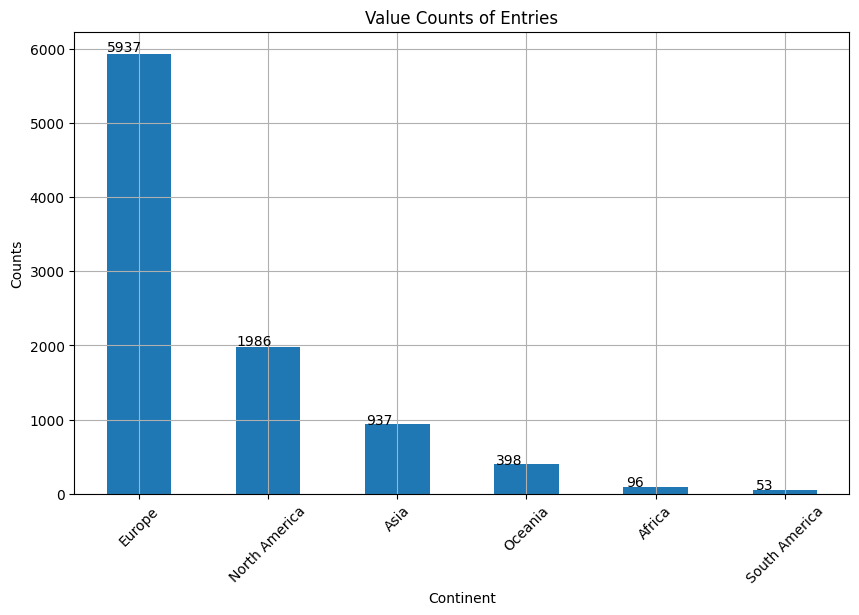

In [36]:
# Plot the bar chart
ax = df2["continent"].value_counts().plot(kind='bar', figsize=(10, 6))
plt.grid()

# Annotate the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.xlabel('Continent')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Value Counts of Entries')
plt.show()

In [37]:
custom_scale = [[0.0, '#d3d3d3'],         # -1 -> gray
                [0.00001, "#4575b4"],  # deep blue
                [0.33, "#91bfdb"], # light blue
                [0.66, "#fdae61"], # orange
                [1.0, "#d73027"]   # red
            ]

fig = choropleth_world(df_merged,
                        value_column='entries_per_tm',
                        color_scale=custom_scale,
                        title='Entries per 10 Million Population (World)',
                        label='Entries/10M',
                        hover_data={
                            'entries_per_tm': True,
                            'population': True,
                            'num_entries': True,
                            'country': False
                        })
fig.show()
fig.write_html("epicov2020_plots/choropleth_entries_per_tm_world.html")

Let's try log scale to reduce variation

In [38]:
df_merged["log_num_entries_per_tm"] = np.log10(df_merged["entries_per_tm"].replace(0, np.nan))
fig = choropleth_world(df_merged,
                        value_column='log_num_entries_per_tm',
                        color_scale=custom_scale,
                        title='Log10(Entries per 10 Million Population) (World)',
                        label='Log10(Entries/10M)',
                        hover_data={
                            'log_num_entries_per_tm': True,
                            'population': True,
                            'num_entries': True,
                            'country': False
                        })
fig.show()

Plot per‐continent maps

In [39]:
# Define custom color scale including a gray value for the sentinel
custom_scale = [
    [0.0, '#d3d3d3'],         # -1 -> gray
    [0.00001, "#4575b4"],  # deep blue
    [0.33, "#91bfdb"], # light blue
    [0.66, "#fdae61"], # orange
    [1.0, "#d73027"]   # red
]

fig = choropleth_continent(df_merged,
                           value_column='entries_per_tm',
                           color_scale=custom_scale,
                           title='Entries per 10 Million Population by Continent',
                           label='Entries/10M',
                           )

fig.show()
fig.write_html("epicov2020_plots/choropleth_entries_per_tm_continents.html")

#### A.2. Gender distribution across countries

Let's next look at the gender distribution across countries again grouped by continents

In [40]:
df_merged["gender_m_per_m"], df_merged["gender_f_per_m"], df_merged["gender_u_per_m"] = float('nan'), float('nan'), float('nan')

for i, row in df_merged.iterrows():
    country = row["country"]
    if country in df2["country"].values:
        # Calculate
        df_merged.loc[i, "gender_m_per_m"] = (df2[(df2["country"] == country) & (df2["Gender"] == "Male")].shape[0])/(row["population"] / 1e6)
        df_merged.loc[i, "gender_f_per_m"] = (df2[(df2["country"] == country) & (df2["Gender"] == "Female")].shape[0])/(row["population"] / 1e6)
        df_merged.loc[i, "gender_u_per_m"] = (df2[(df2["country"] == country) & (df2["Gender"] == "unknown")].shape[0])/(row["population"] / 1e6)

In [41]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 0 to 248
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country                        242 non-null    object 
 1   country_standard               242 non-null    object 
 2   population                     60 non-null     float64
 3   continent                      242 non-null    object 
 4   num_entries                    61 non-null     float64
 5   entries_per_tm                 60 non-null     float64
 6   entries_per_tm_filled          242 non-null    float64
 7   log_num_entries_per_tm         60 non-null     float64
 8   log_num_entries_per_tm_filled  242 non-null    float64
 9   gender_m_per_m                 60 non-null     float64
 10  gender_f_per_m                 60 non-null     float64
 11  gender_u_per_m                 60 non-null     float64
dtypes: float64(9), object(3)
memory usage: 32.7+ KB


For choropleth maps, its better to have 3 different maps one for each gender. First we look at a zoomed out view of the whole world

In [42]:
# World map - distribution of males
# Define custom color scale including a gray value for the sentinel
male_scale = [
    [0.0, "#d3d3d3"],    # -1 or missing -> light grey
    [0.0001, "#cbdbfc"], # very very light blue
    [0.001, "#c6dbef"],     # light blue
    [0.003, "#9ecae1"],     # softer medium blue
    [0.005, "#6bb8d6"],     # medium blue (original mid)
    [0.007, "#3182bd"],     # strong blue
    [0.009, "#08519c"],    # dark blue
    [1.0, "#08306b"]      # very dark blue (original end)
]


fig = choropleth_world(df_merged,
                       value_column="gender_m_per_m",
                       color_scale=male_scale,
                       title="Number of Males per Million Population (World)",
                       label="Males/1M",
                       hover_data={
                            'gender_m_per_m': True,
                            'population': True,
                            'country': False
                        })

fig.show()
fig.write_html("epicov2020_plots/choropleth_males_per_m_world.html")

Since the variation is high, let's try log scale for this map and see if that's better

In [43]:
df_merged["log_males_per_m"] = np.log10(df_merged["gender_m_per_m"].replace(0, np.nan))
df_merged["log_males_per_m"].describe()

count    48.000000
mean     -0.394247
std       1.106048
min      -2.439040
25%      -1.182956
50%      -0.407838
75%       0.212299
max       2.914536
Name: log_males_per_m, dtype: float64

In [44]:
df_merged[df_merged["country"]=="Nigeria"]

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,gender_f_per_m,gender_u_per_m,gender_m_per_m_filled,log_males_per_m
163,Nigeria,Nigeria,213996181.0,Africa,1.0,0.04673,0.04673,-1.330406,-1.330406,0.004673,0.0,0.0,0.004673,-2.330406


In [45]:
dict(df_merged["log_males_per_m"].describe())["min"], dict(df_merged["log_males_per_m"].describe())["max"]

(np.float64(-2.4390402220088427), np.float64(2.9145363630205234))

In [46]:
zmin, zmax = np.floor(dict(df_merged["log_males_per_m"].describe())["min"]), np.ceil(dict(df_merged["log_males_per_m"].describe())["max"])
df_merged["log_males_per_m_adjusted"] = df_merged["log_males_per_m"].apply(lambda x: (x - zmin) / (zmax - zmin) if pd.notnull(x) else x)
df_merged["log_males_per_m_adjusted"].describe()

count    48.000000
mean      0.434292
std       0.184341
min       0.093493
25%       0.302841
50%       0.432027
75%       0.535383
max       0.985756
Name: log_males_per_m_adjusted, dtype: float64

In [47]:
male_scale1 = [
    [0.0, "#d3d3d3"],    # -1 or missing -> light grey
    [0.0001, "#cbdbfc"], # very very light blue
    [0.25, "#c6dbef"],     # light blue
    [0.5, "#6bb8d6"],     # medium blue (original mid)
    [0.75, "#08519c"],    # dark blue
    [1.0, "#08306b"]      # very dark blue (original end)
]

fig = choropleth_world(df_merged,
                       value_column="log_males_per_m_adjusted",
                       color_scale=male_scale1,
                       title="Number of Males per Million Population (World) | log scale",
                       label="Males/1M",
                       hover_data={
                            'gender_m_per_m': True,
                            "log_males_per_m": True,
                            'population': True,
                            'country': False
                        })

fig.show()

In [48]:
cont_av_males = [(a,df_merged[(df_merged["continent"]==a)&(df_merged["gender_m_per_m_filled"] >= 0)]["gender_m_per_m"].mean()) for a in df_merged["continent"].unique()]
asc = sorted(cont_av_males, key=lambda x: x[1])
df_m = df_merged[df_merged["gender_m_per_m_filled"] >= 0].sort_values(by=["gender_m_per_m_filled"], ascending=True)
asc

[('South America', np.float64(0.1067359775216676)),
 ('Africa', np.float64(0.22894195329804015)),
 ('North America', np.float64(0.5977673324955471)),
 ('Asia', np.float64(0.8851963540206966)),
 ('Oceania', np.float64(4.408624143381417)),
 ('Europe', np.float64(36.68853508414393)),
 ('Antarctica', nan)]

In [49]:
df_m.head(10)

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,gender_f_per_m,gender_u_per_m,gender_m_per_m_filled,log_males_per_m,log_males_per_m_adjusted,log_males_per_m_adjusted_filled
28,Belarus,Belarus,9379952.0,Europe,2.0,2.132207,2.132207,0.328829,0.328829,0.0,0.000000,0.213221,0.0,NaN,NaN,-1.0
70,Estonia,Estonia,1329522.0,Europe,4.0,30.086001,30.086001,1.478364,1.478364,0.0,0.000000,3.008600,0.0,NaN,NaN,-1.0
89,Greece,Greece,10698599.0,Europe,3.0,2.804105,2.804105,0.447794,0.447794,0.0,0.000000,0.280411,0.0,NaN,NaN,-1.0
175,Peru,Peru,32838579.0,South America,1.0,0.304520,0.304520,-0.516384,-0.516384,0.0,0.030452,0.000000,0.0,NaN,NaN,-1.0
166,Netherlands,Netherlands,17441500.0,Europe,585.0,335.406932,335.406932,2.525572,2.525572,0.0,0.000000,33.540693,0.0,NaN,NaN,-1.0
167,Norway,Norway,5379475.0,Europe,29.0,53.908606,53.908606,1.731658,1.731658,0.0,0.000000,5.390861,0.0,NaN,NaN,-1.0
134,Latvia,Latvia,1900449.0,Europe,5.0,26.309572,26.309572,1.420114,1.420114,0.0,0.000000,2.630957,0.0,NaN,NaN,-1.0
218,Thailand,Thailand,71641484.0,Asia,7.0,0.977088,0.977088,-0.010067,-0.010067,0.0,0.027917,0.069792,0.0,NaN,NaN,-1.0
176,Philippines,Philippines,112081264.0,Asia,4.0,0.356884,0.356884,-0.447473,-0.447473,0.0,0.000000,0.035688,0.0,NaN,NaN,-1.0
210,Sweden,Sweden,10353442.0,Europe,2.0,1.931725,1.931725,0.285945,0.285945,0.0,0.000000,0.193172,0.0,NaN,NaN,-1.0


In [50]:
df_m.tail(10)

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,gender_f_per_m,gender_u_per_m,gender_m_per_m_filled,log_males_per_m,log_males_per_m_adjusted,log_males_per_m_adjusted_filled
80,Georgia,Georgia,3722716.0,Asia,23.0,61.782849,61.782849,1.790868,1.790868,2.417590,1.343105,2.417590,2.417590,0.383383,0.563897,0.563897
182,Portugal,Portugal,10297081.0,Europe,90.0,87.403411,87.403411,1.941528,1.941528,4.175941,4.078826,0.485575,4.175941,0.620754,0.603459,0.603459
194,Singapore,Singapore,5685807.0,Asia,45.0,79.144438,79.144438,1.898420,1.898420,4.221037,3.693407,0.000000,4.221037,0.625419,0.604237,0.604237
72,Finland,Finland,5529543.0,Europe,40.0,72.338709,72.338709,1.859371,1.859371,4.340323,2.893548,0.000000,4.340323,0.637522,0.606254,0.606254
96,Hong Kong,Hong Kong,7481000.0,Asia,158.0,211.201711,211.201711,2.324697,2.324697,6.015239,6.148911,8.956022,6.015239,0.779253,0.629875,0.629875
14,Australia,Australia,25649248.0,Oceania,391.0,152.441116,152.441116,2.183102,2.183102,8.031425,6.004075,1.208612,8.031425,0.904793,0.650799,0.650799
18,Belgium,Belgium,11538604.0,Europe,341.0,295.529685,295.529685,2.470601,2.470601,12.826508,12.133184,4.593277,12.826508,1.108108,0.684685,0.684685
79,United Kingdom,United Kingdom,67081234.0,Europe,3526.0,525.631356,525.631356,2.720681,2.720681,26.356104,19.737264,6.469768,26.356104,1.420881,0.736814,0.736814
133,Luxembourg,Luxembourg,630419.0,Europe,86.0,1364.172082,1364.172082,3.134869,3.134869,72.967344,61.863618,1.586247,72.967344,1.863129,0.810521,0.810521
109,Iceland,Iceland,366463.0,Europe,601.0,16400.018556,16400.018556,4.214844,4.214844,821.365322,750.416822,68.219711,821.365322,2.914536,0.985756,0.985756


In [51]:
# World map - distribution of females
# Define custom color scale including a gray value for the sentinel
female_scale = [
    [0.0, "#d3d3d3"],    # -1 or missing -> light grey
    [0.0001, "#ffb2d5"], # very light pink
    [0.001, "#ffafcb"],    # light pink
    [0.003, "#fa9fb5"],    # medium pink
    [0.005, "#f768a1"],    # dark pink
    [0.007, "#c51b8a"],    # dark magenta
    [1.0, "#7a0177"]     # deep maroon
]

fig = choropleth_world(df_merged,
                       value_column="gender_f_per_m",
                       color_scale=female_scale,
                       title="Number of Females per Million Population (World)",
                       label="Females/1M",
                       hover_data={
                            'gender_f_per_m': True,
                            'population': True,
                            'country': False
                        })

fig.show()
fig.write_html("epicov2020_plots/choropleth_females_per_m_world.html")

In [52]:
cont_av_f = [(a,df_merged[(df_merged["continent"]==a)&(df_merged["gender_f_per_m_filled"] >= 0)]["gender_f_per_m"].mean()) for a in df_merged["continent"].unique()]
asc = sorted(cont_av_f, key=lambda x: x[1])
df_f = df_merged[df_merged["gender_f_per_m_filled"] >= 0].sort_values(by=["gender_f_per_m_filled"], ascending=True)
asc

[('South America', np.float64(0.04296565667972249)),
 ('Africa', np.float64(0.17601744642197772)),
 ('North America', np.float64(0.6306519136941027)),
 ('Asia', np.float64(0.7363195795170743)),
 ('Oceania', np.float64(3.296721233085786)),
 ('Europe', np.float64(33.02737250314098)),
 ('Antarctica', nan)]

In [53]:
df_f.head(10)

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,gender_f_per_m,gender_u_per_m,gender_m_per_m_filled,log_males_per_m,log_males_per_m_adjusted,log_males_per_m_adjusted_filled,gender_f_per_m_filled
8,Argentina,Argentina,45191965.0,South America,3.0,0.663835,0.663835,-0.177940,-0.177940,0.066383,0.0,0.000000,0.066383,-1.177940,0.303677,0.303677,0.0
28,Belarus,Belarus,9379952.0,Europe,2.0,2.132207,2.132207,0.328829,0.328829,0.000000,0.0,0.213221,0.000000,NaN,NaN,-1.000000,0.0
65,Ecuador,Ecuador,17546065.0,South America,4.0,2.279713,2.279713,0.357880,0.357880,0.227971,0.0,0.000000,0.227971,-0.642120,0.392980,0.392980,0.0
70,Estonia,Estonia,1329522.0,Europe,4.0,30.086001,30.086001,1.478364,1.478364,0.000000,0.0,3.008600,0.000000,NaN,NaN,-1.000000,0.0
89,Greece,Greece,10698599.0,Europe,3.0,2.804105,2.804105,0.447794,0.447794,0.000000,0.0,0.280411,0.000000,NaN,NaN,-1.000000,0.0
176,Philippines,Philippines,112081264.0,Asia,4.0,0.356884,0.356884,-0.447473,-0.447473,0.000000,0.0,0.035688,0.000000,NaN,NaN,-1.000000,0.0
210,Sweden,Sweden,10353442.0,Europe,2.0,1.931725,1.931725,0.285945,0.285945,0.000000,0.0,0.193172,0.000000,NaN,NaN,-1.000000,0.0
179,Poland,Poland,37899070.0,Europe,1.0,0.263859,0.263859,-0.578629,-0.578629,0.026386,0.0,0.000000,0.026386,-1.578629,0.236895,0.236895,0.0
163,Nigeria,Nigeria,213996181.0,Africa,1.0,0.046730,0.046730,-1.330406,-1.330406,0.004673,0.0,0.000000,0.004673,-2.330406,0.111599,0.111599,0.0
166,Netherlands,Netherlands,17441500.0,Europe,585.0,335.406932,335.406932,2.525572,2.525572,0.000000,0.0,33.540693,0.000000,NaN,NaN,-1.000000,0.0


In [54]:
df_f.tail(10)

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,gender_f_per_m,gender_u_per_m,gender_m_per_m_filled,log_males_per_m,log_males_per_m_adjusted,log_males_per_m_adjusted_filled,gender_f_per_m_filled
39,Canada,Canada,38028638.0,North America,129.0,33.921804,33.921804,1.530479,1.530479,1.604054,1.525166,0.262960,1.604054,0.205219,0.534203,0.534203,1.525166
72,Finland,Finland,5529543.0,Europe,40.0,72.338709,72.338709,1.859371,1.859371,4.340323,2.893548,0.000000,4.340323,0.637522,0.606254,0.606254,2.893548
194,Singapore,Singapore,5685807.0,Asia,45.0,79.144438,79.144438,1.898420,1.898420,4.221037,3.693407,0.000000,4.221037,0.625419,0.604237,0.604237,3.693407
182,Portugal,Portugal,10297081.0,Europe,90.0,87.403411,87.403411,1.941528,1.941528,4.175941,4.078826,0.485575,4.175941,0.620754,0.603459,0.603459,4.078826
14,Australia,Australia,25649248.0,Oceania,391.0,152.441116,152.441116,2.183102,2.183102,8.031425,6.004075,1.208612,8.031425,0.904793,0.650799,0.650799,6.004075
96,Hong Kong,Hong Kong,7481000.0,Asia,158.0,211.201711,211.201711,2.324697,2.324697,6.015239,6.148911,8.956022,6.015239,0.779253,0.629875,0.629875,6.148911
18,Belgium,Belgium,11538604.0,Europe,341.0,295.529685,295.529685,2.470601,2.470601,12.826508,12.133184,4.593277,12.826508,1.108108,0.684685,0.684685,12.133184
79,United Kingdom,United Kingdom,67081234.0,Europe,3526.0,525.631356,525.631356,2.720681,2.720681,26.356104,19.737264,6.469768,26.356104,1.420881,0.736814,0.736814,19.737264
133,Luxembourg,Luxembourg,630419.0,Europe,86.0,1364.172082,1364.172082,3.134869,3.134869,72.967344,61.863618,1.586247,72.967344,1.863129,0.810521,0.810521,61.863618
109,Iceland,Iceland,366463.0,Europe,601.0,16400.018556,16400.018556,4.214844,4.214844,821.365322,750.416822,68.219711,821.365322,2.914536,0.985756,0.985756,750.416822


In [55]:
# World map - distribution of females
# Define custom color scale including a gray value for the sentinel
unknown_scale = [
    [0.0, "#d3d3d3"],    # -1 or missing -> light grey
    [0.0001, "#fff7e6"], # very pale tan
    [0.001, "#fee8c8"],     # very light tan
    [0.003, "#fdd49e"],     # light tan-orange
    [0.005, "#fdbb84"],     # medium golden tan
    [0.007, "#e08214"],     # golden brown
    [1.0, "#8c510a"]      # dark brown
]

fig = choropleth_world(df_merged,
                       value_column="gender_u_per_m",
                       color_scale=unknown_scale,
                       title="Number of Unknown gender per Million Population (World)",
                       label="Missing gender/1M",
                       hover_data={
                            'gender_u_per_m': True,
                            'population': True,
                            'country': False
                        })

fig.show()
fig.write_html("epicov2020_plots/choropleth_unknown_gender_per_m_world.html")

In [56]:
cont_av_u = [(a,df_merged[(df_merged["continent"]==a)&(df_merged["gender_u_per_m_filled"] >= 0)]["gender_u_per_m"].mean()) for a in df_merged["continent"].unique()]
asc = sorted(cont_av_u, key=lambda x: x[1])
df_u = df_merged[df_merged["gender_u_per_m_filled"] >= 0].sort_values(by=["gender_u_per_m_filled"], ascending=True)
asc

[('South America', np.float64(0.0)),
 ('Africa', np.float64(0.013918980564955274)),
 ('Oceania', np.float64(0.6043062159171294)),
 ('Asia', np.float64(0.825648384369922)),
 ('North America', np.float64(1.0920517198749857)),
 ('Europe', np.float64(5.012756779979227)),
 ('Antarctica', nan)]

In [57]:
df_p = df_merged[["country_standard","continent"]].drop_duplicates().dropna()
df_p["continent"].value_counts()

continent
Africa           57
Asia             53
Europe           50
North America    40
Oceania          24
South America    15
Antarctica        3
Name: count, dtype: int64

In [58]:
df_u[df_u["gender_u_per_m_filled"]==0.0]["continent"].value_counts()

continent
Europe           8
Asia             7
South America    6
Africa           5
North America    2
Oceania          1
Name: count, dtype: int64

In [59]:
df_u[df_u["gender_u_per_m_filled"]==0.0]

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,gender_f_per_m,gender_u_per_m,gender_m_per_m_filled,log_males_per_m,log_males_per_m_adjusted,log_males_per_m_adjusted_filled,gender_f_per_m_filled,gender_u_per_m_filled
8,Argentina,Argentina,45191965.0,South America,3.0,0.663835,0.663835,-0.177940,-0.177940,0.066383,0.000000,0.0,0.066383,-1.177940,0.303677,0.303677,0.000000,0.0
15,Austria,Austria,8916864.0,Europe,21.0,23.550881,23.550881,1.372007,1.372007,1.457912,0.897176,0.0,1.457912,0.163731,0.527289,0.527289,0.897176,0.0
32,Brazil,Brazil,208660842.0,South America,36.0,1.725288,1.725288,0.236862,0.236862,0.119812,0.052717,0.0,0.119812,-0.921501,0.346417,0.346417,0.052717,0.0
65,Ecuador,Ecuador,17546065.0,South America,4.0,2.279713,2.279713,0.357880,0.357880,0.227971,0.000000,0.0,0.227971,-0.642120,0.392980,0.392980,0.000000,0.0
62,Denmark,Denmark,5831404.0,Europe,9.0,15.433676,15.433676,1.188469,1.188469,1.371882,0.171485,0.0,1.371882,0.137317,0.522886,0.522886,0.171485,0.0
64,Algeria,Algeria,44042091.0,Africa,3.0,0.681167,0.681167,-0.166747,-0.166747,0.045411,0.022706,0.0,0.045411,-1.342838,0.276194,0.276194,0.022706,0.0
49,Colombia,Colombia,50629997.0,South America,2.0,0.395023,0.395023,-0.403378,-0.403378,0.019751,0.019751,0.0,0.019751,-1.704408,0.215932,0.215932,0.019751,0.0
42,Chile,Chile,19370624.0,South America,7.0,3.613719,3.613719,0.557954,0.557954,0.206498,0.154874,0.0,0.206498,-0.685084,0.385819,0.385819,0.154874,0.0
101,Hungary,Hungary,9750149.0,Europe,3.0,3.076876,3.076876,0.488110,0.488110,0.205125,0.102563,0.0,0.205125,-0.687981,0.385336,0.385336,0.102563,0.0
102,Indonesia,Indonesia,274814866.0,Asia,4.0,0.145553,0.145553,-0.836980,-0.836980,0.003639,0.010916,0.0,0.003639,-2.439040,0.093493,0.093493,0.010916,0.0


In [60]:
df_u.tail(10)

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,gender_f_per_m,gender_u_per_m,gender_m_per_m_filled,log_males_per_m,log_males_per_m_adjusted,log_males_per_m_adjusted_filled,gender_f_per_m_filled,gender_u_per_m_filled
41,Switzerland,Switzerland,8638167.0,Europe,49.0,56.724997,56.724997,1.753774,1.753774,1.852245,1.389184,2.431071,1.852245,0.267698,0.544616,0.544616,1.389184,2.431071
134,Latvia,Latvia,1900449.0,Europe,5.0,26.309572,26.309572,1.420114,1.420114,0.000000,0.000000,2.630957,0.000000,NaN,NaN,-1.000000,0.000000,2.630957
70,Estonia,Estonia,1329522.0,Europe,4.0,30.086001,30.086001,1.478364,1.478364,0.000000,0.000000,3.008600,0.000000,NaN,NaN,-1.000000,0.000000,3.008600
234,United States,United States,331526933.0,North America,1844.0,55.621424,55.621424,1.745242,1.745242,0.723923,0.732972,4.105247,0.723923,-0.140308,0.476615,0.476615,0.732972,4.105247
18,Belgium,Belgium,11538604.0,Europe,341.0,295.529685,295.529685,2.470601,2.470601,12.826508,12.133184,4.593277,12.826508,1.108108,0.684685,0.684685,12.133184,4.593277
167,Norway,Norway,5379475.0,Europe,29.0,53.908606,53.908606,1.731658,1.731658,0.000000,0.000000,5.390861,0.000000,NaN,NaN,-1.000000,0.000000,5.390861
79,United Kingdom,United Kingdom,67081234.0,Europe,3526.0,525.631356,525.631356,2.720681,2.720681,26.356104,19.737264,6.469768,26.356104,1.420881,0.736814,0.736814,19.737264,6.469768
96,Hong Kong,Hong Kong,7481000.0,Asia,158.0,211.201711,211.201711,2.324697,2.324697,6.015239,6.148911,8.956022,6.015239,0.779253,0.629875,0.629875,6.148911,8.956022
166,Netherlands,Netherlands,17441500.0,Europe,585.0,335.406932,335.406932,2.525572,2.525572,0.000000,0.000000,33.540693,0.000000,NaN,NaN,-1.000000,0.000000,33.540693
109,Iceland,Iceland,366463.0,Europe,601.0,16400.018556,16400.018556,4.214844,4.214844,821.365322,750.416822,68.219711,821.365322,2.914536,0.985756,0.985756,750.416822,68.219711


Now we plot the continent-wise choropleth maps

In [61]:
fig = choropleth_continent(df_merged,
                           value_column='gender_m_per_m',
                           color_scale=male_scale,
                           title="Number of Males per Million Population by Continent",
                           label="Males/1M",
                           )

fig.show()
fig.write_html("epicov2020_plots/choropleth_males_per_m_continents.html")

Let's try log scale here too

In [62]:
fig = choropleth_continent(df_merged,
                           value_column='log_males_per_m_adjusted',
                           color_scale=male_scale1,
                           title="Number of Males per Million Population by Continent | log scale",
                           label="Males/1M",
                           )

fig.show()

In [63]:
fig = choropleth_continent(df_merged,
                           value_column='gender_f_per_m',
                           color_scale=female_scale,
                           title="Number of Females per Million Population by Continent",
                           label="Females/1M",
                           )

fig.show()
fig.write_html("epicov2020_plots/choropleth_females_per_m_continents.html")

In [64]:
fig = choropleth_continent(df_merged,
                           value_column='gender_u_per_m',
                           color_scale=unknown_scale,
                           title="Number of Missing gender per Million Population by Continent",
                           label="Missing gender/1M",
                           )

fig.show()
fig.write_html("epicov2020_plots/choropleth_unknown_gender_per_m_continents.html")

Let's see how the gender ratio is across continents and countries

In [65]:
df_merged["male_female_ratio"] = df_merged["gender_m_per_m"] / df_merged["gender_f_per_m"].replace(0, np.nan)
df_merged["male_female_ratio"].describe()

count    44.000000
mean      1.416635
std       1.252082
min       0.000000
25%       0.996914
50%       1.158385
75%       1.668750
max       8.000000
Name: male_female_ratio, dtype: float64

In [66]:
custom_rdbu_with_gray = [
    [0.0, "#d3d3d3"],     # Missing / -1 → light gray
    [0.05, "#053061"], # Deep blue
    [0.1, "#2166ac"],    # Blue
    [0.33, "#f7f7f7"],     # White (neutral)
    [0.66, "#b2182b"],    # Red
    [1.0, "#67001f"]      # Deep red
]

fig = choropleth_world(df_merged,
                       value_column="male_female_ratio",
                       color_scale=custom_rdbu_with_gray,
                       title="Male to Female ratio (World)",
                       label="Gender ratio",
                       hover_data={
                            'male_female_ratio': True,
                            'population': True,
                            'country': False
                        })

fig.show()

In [67]:
fig = choropleth_continent(df_merged,
                           value_column='male_female_ratio',
                           color_scale=custom_rdbu_with_gray,
                           title="Gender ratio by Continent",
                           label="Gender ratio",
                            hover_data={"male_female_ratio": True,
                                        "population": True,
                                        "country": False}
                           )

fig.show()

#### A.3. Patient status distribution across countries

Let's next look at the patient status distribution across countries again grouped by continents

In [68]:
list(df2["Patient status"].unique())

['unknown',
 'Hospitalized',
 'Released',
 'Recovering',
 'Discharged',
 'Live',
 'Asymptomatic',
 'Symptomatic',
 'Recovered',
 nan,
 'Stable in quarantine',
 'EHPAD',
 'Epidemiology Study',
 'Mild symptoms (fever, cardiovascular disorders)',
 'Pneumonia (chest X-ray), not critical',
 'Hospitalized (Mild)',
 'Hospitalized (Stable)',
 'Deceased',
 'ICU; Serious',
 'Intensive Care Unit',
 'Hospitalized (Intensive care unit)',
 'Mild',
 'Pneumonia (chest X-ray)',
 'Initially hospitalized, but now improved and discharged',
 'Screening']

As we see there are a lot of overlapping categories. Let us group them together into meaningful categories as follows

In [69]:
status_mapping = {
    'unknown': 'Unknown/Missing',
    'Epidemiology Study': 'Unknown/Missing',
    'Screening': 'Unknown/Missing',
    np.nan: 'Unknown/Missing',

    'Asymptomatic': 'Mild/Recovering',
    'Mild': 'Mild/Recovering',
    'Mild symptoms (fever, cardiovascular disorders)': 'Mild/Recovering',
    'Recovering': 'Mild/Recovering',
    'Recovered': 'Mild/Recovering',
    'Stable in quarantine': 'Mild/Recovering',

    'Hospitalized (Mild)': 'Hospitalized - Mild/Stable',
    'Hospitalized (Stable)': 'Hospitalized - Mild/Stable',
    'Pneumonia (chest X-ray), not critical': 'Hospitalized - Mild/Stable',
    'Pneumonia (chest X-ray)': 'Hospitalized - Mild/Stable',

    'ICU; Serious': 'Hospitalized - Intensive/Critical',
    'Intensive Care Unit': 'Hospitalized - Intensive/Critical',
    'Hospitalized (Intensive care unit)': 'Hospitalized - Intensive/Critical',

    'Deceased': 'Deceased',

    'Discharged': 'Discharged/Released',
    'Released': 'Discharged/Released',
    'Live': 'Discharged/Released',
    'Initially hospitalized, but now improved and discharged': 'Discharged/Released',

    'Hospitalized': 'Hospitalized (General)',

    'EHPAD': 'Nursing Home',

    'Symptomatic': 'Symptomatic (Unspecified)'
}

severity_level = {
    'Mild/Recovering': 'Least Severe',
    'Discharged/Released': 'Least Severe',
    
    'Symptomatic (Unspecified)': 'Mild',
    'Hospitalized - Mild/Stable': 'Mild',
    'Hospitalized (General)': 'Mild',
    'Nursing Home': 'Mild',
    
    'Hospitalized - Intensive/Critical': 'Severe',
    'Deceased': 'Severe',
    
    'Unknown/Missing': 'Unknown'
}

Now we apply this mapping to the dataframe

In [70]:
df2['status_category'] = df2['Patient status'].map(status_mapping)
df2['status_category'].value_counts()

status_category
Unknown/Missing                      8822
Hospitalized (General)                299
Discharged/Released                   121
Mild/Recovering                        86
Hospitalized - Mild/Stable             30
Symptomatic (Unspecified)              25
Nursing Home                           13
Hospitalized - Intensive/Critical       6
Deceased                                5
Name: count, dtype: int64

In [71]:
df2["severity_level"] = df2["status_category"].map(severity_level)
df2["severity_level"].value_counts()

severity_level
Unknown         8822
Mild             367
Least Severe     207
Severe            11
Name: count, dtype: int64

In [72]:
df_merged["status_l_per_m"], df_merged["status_m_per_m"], df_merged["status_s_per_m"], df_merged["status_u_per_m"] = float('nan'), float('nan'), float('nan'), float('nan')

for i, row in df_merged.iterrows():
    country = row["country"]
    if country in df2["country"].values:
        # Calculate
        df_merged.loc[i, "status_l_per_m"] = (df2[(df2["country"] == country) & (df2["severity_level"] == "Least Severe")].shape[0])/(row["population"] / 1e6)
        df_merged.loc[i, "status_m_per_m"] = (df2[(df2["country"] == country) & (df2["severity_level"] == "Mild")].shape[0])/(row["population"] / 1e6)
        df_merged.loc[i, "status_s_per_m"] = (df2[(df2["country"] == country) & (df2["severity_level"] == "Severe")].shape[0])/(row["population"] / 1e6)
        df_merged.loc[i, "status_u_per_m"] = (df2[(df2["country"] == country) & (df2["severity_level"] == "Unknown")].shape[0])/(row["population"] / 1e6)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 0 to 248
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          242 non-null    object 
 1   country_standard                 242 non-null    object 
 2   population                       60 non-null     float64
 3   continent                        242 non-null    object 
 4   num_entries                      61 non-null     float64
 5   entries_per_tm                   60 non-null     float64
 6   entries_per_tm_filled            242 non-null    float64
 7   log_num_entries_per_tm           60 non-null     float64
 8   log_num_entries_per_tm_filled    242 non-null    float64
 9   gender_m_per_m                   60 non-null     float64
 10  gender_f_per_m                   60 non-null     float64
 11  gender_u_per_m                   60 non-null     float64
 12  gender_m_per_m_filled      

For choropleth maps, its better to have 4 different maps one for each severity level. First we look at a zoomed out view of the whole world

In [73]:
# World map - distribution of least severe cases
# Define custom color scale including a gray value for the sentinel
least_severe_scale = [
    [0.0, "#d3d3d3"],    # -1 or missing -> light grey
    [0.0001, "#f7fcf5"], # very pale green
    [0.01, "#e5f5e0"],  # very light green
    [0.03, "#c7e9c0"],  # light green
    [0.1, "#a1d99b"],  # medium light green
    [0.5, "#41ab5d"],  # strong green
    [1.0, "#006837"]     # dark forest green
]

fig = choropleth_world(df_merged,
                       value_column="status_l_per_m",
                       color_scale=least_severe_scale,
                       title="Number of least severe cases per Million Population (World)",
                       label="least severe/1M",
                       hover_data={
                            'status_l_per_m': True,
                            'population': True,
                            'country': False
                        })

fig.show()
fig.write_html("epicov2020_plots/choropleth_least_severe_per_m_world.html")

In [74]:
cont_av_l = [(a,df_merged[(df_merged["continent"]==a)&(df_merged["status_l_per_m_filled"] >= 0)]["status_l_per_m"].mean()) for a in df_merged["continent"].unique()]
asc = sorted(cont_av_l, key=lambda x: x[1])
df_l = df_merged[df_merged["status_l_per_m_filled"] >= 0].sort_values(by=["status_l_per_m_filled"], ascending=True)
asc

[('North America', np.float64(0.0015081730931344876)),
 ('South America', np.float64(0.02557148255718433)),
 ('Europe', np.float64(0.07356036287758666)),
 ('Oceania', np.float64(0.23392498680663074)),
 ('Africa', np.float64(0.23657707299370132)),
 ('Asia', np.float64(0.252209666586044)),
 ('Antarctica', nan)]

In [75]:
df_l[df_l["status_l_per_m_filled"]==0.0].shape

(37, 25)

In [76]:
df_l.tail(10)

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,...,log_males_per_m_adjusted_filled,gender_f_per_m_filled,gender_u_per_m_filled,male_female_ratio,male_female_ratio_filled,status_l_per_m,status_m_per_m,status_s_per_m,status_u_per_m,status_l_per_m_filled
101,Hungary,Hungary,9750149.0,Europe,3.0,3.076876,3.076876,0.488110,0.488110,0.205125,...,0.385336,0.102563,0.000000,2.000000,2.000000,0.102563,0.205125,0.000000,0.000000,0.102563
157,Malaysia,Malaysia,33889558.0,Asia,13.0,3.835990,3.835990,0.583877,0.583877,0.118030,...,0.345332,0.177046,0.088523,0.666667,0.666667,0.177046,0.000000,0.059015,0.147538,0.177046
58,Czechia,Czechia,10697858.0,Europe,7.0,6.543366,6.543366,0.815801,0.815801,0.373907,...,0.428794,0.093477,0.186953,4.000000,4.000000,0.186953,0.000000,0.000000,0.467383,0.186953
14,Australia,Australia,25649248.0,Oceania,391.0,152.441116,152.441116,2.183102,2.183102,8.031425,...,0.650799,6.004075,1.208612,1.337662,1.337662,0.467850,0.077975,0.000000,14.698287,0.467850
115,Japan,Japan,126261000.0,Asia,103.0,8.157705,8.157705,0.911568,0.911568,0.071281,...,0.308829,0.102961,0.641528,0.692308,0.692308,0.491046,0.229683,0.007920,0.087121,0.491046
62,Denmark,Denmark,5831404.0,Europe,9.0,15.433676,15.433676,1.188469,1.188469,1.371882,...,0.522886,0.171485,0.000000,8.000000,8.000000,0.514456,0.000000,0.000000,1.028912,0.514456
123,Kuwait,Kuwait,4400267.0,Asia,8.0,18.180715,18.180715,1.259611,1.259611,0.909036,...,0.493097,0.000000,0.909036,NaN,-1.000000,0.681777,0.227259,0.000000,0.909036,0.681777
18,Belgium,Belgium,11538604.0,Europe,341.0,295.529685,295.529685,2.470601,2.470601,12.826508,...,0.684685,12.133184,4.593277,1.057143,1.057143,1.039987,6.326589,0.000000,22.186393,1.039987
193,Senegal,Senegal,16789219.0,Africa,23.0,13.699267,13.699267,1.136697,1.136697,0.893430,...,0.491843,0.476496,0.000000,1.875000,1.875000,1.369927,0.000000,0.000000,0.000000,1.369927
96,Hong Kong,Hong Kong,7481000.0,Asia,158.0,211.201711,211.201711,2.324697,2.324697,6.015239,...,0.629875,6.148911,8.956022,0.978261,0.978261,2.539767,3.341799,0.401016,14.837589,2.539767


In [77]:
# World map - distribution of mildly severe cases
# Define custom color scale including a gray value for the sentinel
mild_severe_scale = [
    [0.0, "#d3d3d3"],    # -1 or missing -> light grey
    [0.0001, "#fff5eb"], # very pale orange
    [0.001, "#fee6ce"],  # very light orange
    [0.003, "#fdd0a2"],  # light orange
    [0.005, "#fdae6b"],  # medium orange
    [0.007, "#e6550d"],  # deep orange
    [1.0, "#a63603"]     # dark burnt orange
]


fig = choropleth_world(df_merged,
                       value_column="status_m_per_m",
                       color_scale=mild_severe_scale,
                       title="Number of mildly severe cases per Million Population (World)",
                       label="mildly severe/1M",
                       hover_data={
                            'status_m_per_m': True,
                            'population': True,
                            'country': False
                        })

fig.show()
fig.write_html("epicov2020_plots/choropleth_mildly_severe_per_m_world.html")

In [78]:
cont_av_m = [(a,df_merged[(df_merged["continent"]==a)&(df_merged["status_m_per_m_filled"] >= 0)]["status_m_per_m"].mean()) for a in df_merged["continent"].unique()]
asc = sorted(cont_av_m, key=lambda x: x[1])
df_m = df_merged[df_merged["status_m_per_m_filled"] >= 0].sort_values(by=["status_m_per_m_filled"], ascending=True)
asc

[('North America', np.float64(0.00197162354223873)),
 ('Africa', np.float64(0.012131606241385972)),
 ('South America', np.float64(0.03879396815105962)),
 ('Oceania', np.float64(0.1372154652680023)),
 ('Asia', np.float64(0.3235978946791181)),
 ('Europe', np.float64(0.3645730212725005)),
 ('Antarctica', nan)]

In [79]:
df_m[df_m["status_m_per_m_filled"]==0.0]["continent"].value_counts()

continent
Europe           18
Asia             10
South America     4
Africa            4
North America     3
Name: count, dtype: int64

In [80]:
df_m[df_m["status_m_per_m_filled"]==0.0].shape

(39, 26)

In [81]:
df_m.tail()

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,...,gender_f_per_m_filled,gender_u_per_m_filled,male_female_ratio,male_female_ratio_filled,status_l_per_m,status_m_per_m,status_s_per_m,status_u_per_m,status_l_per_m_filled,status_m_per_m_filled
69,Spain,Spain,47365655.0,Europe,150.0,31.668516,31.668516,1.500628,1.500628,1.710100,...,1.456752,0.000000,1.173913,1.173913,0.042225,0.612258,0.000000,2.512369,0.042225,0.612258
80,Georgia,Georgia,3722716.0,Asia,23.0,61.782849,61.782849,1.790868,1.790868,2.417590,...,1.343105,2.417590,1.800000,1.800000,0.000000,1.343105,0.000000,4.835179,0.000000,1.343105
75,France,France,67601110.0,Europe,205.0,30.324946,30.324946,1.481800,1.481800,1.420095,...,1.405302,0.207097,1.010526,1.010526,0.000000,1.641985,0.000000,1.390510,0.000000,1.641985
96,Hong Kong,Hong Kong,7481000.0,Asia,158.0,211.201711,211.201711,2.324697,2.324697,6.015239,...,6.148911,8.956022,0.978261,0.978261,2.539767,3.341799,0.401016,14.837589,2.539767,3.341799
18,Belgium,Belgium,11538604.0,Europe,341.0,295.529685,295.529685,2.470601,2.470601,12.826508,...,12.133184,4.593277,1.057143,1.057143,1.039987,6.326589,0.000000,22.186393,1.039987,6.326589


In [82]:
# World map - distribution of very severe cases
# Define custom color scale including a gray value for the sentinel
very_severe_scale = [
    [0.0, "#d3d3d3"],    # -1 or missing -> light grey
    [0.0001, "#fff5f0"], # very pale red
    [0.001, "#fee0d2"],  # very light red
    [0.1, "#fcbba1"],  # light red
    [0.3, "#ffa488"],  # medium red
    [0.5, "#fe544e"],  # deep red
    [1.0, "#a50f15"]     # dark crimson red
]


fig = choropleth_world(df_merged,
                       value_column="status_s_per_m",
                       color_scale=very_severe_scale,
                       title="Number of very severe cases per Million Population (World)",
                       label="very severe/1M",
                       hover_data={
                            'status_s_per_m': True,
                            'population': True,
                            'country': False
                        })

fig.show()
fig.write_html("epicov2020_plots/choropleth_very_severe_per_m_world.html")

In [83]:
cont_av_s = [(a,df_merged[(df_merged["continent"]==a)&(df_merged["status_s_per_m_filled"] >= 0)]["status_s_per_m"].mean()) for a in df_merged["continent"].unique()]
asc = sorted(cont_av_s, key=lambda x: x[1])
df_s = df_merged[df_merged["status_s_per_m_filled"] >= 0].sort_values(by=["status_s_per_m_filled"], ascending=True)
asc

[('North America', np.float64(0.0)),
 ('Africa', np.float64(0.0)),
 ('Oceania', np.float64(0.0)),
 ('South America', np.float64(0.0007987443406687043)),
 ('Europe', np.float64(0.012940044323275019)),
 ('Asia', np.float64(0.029246952325356308)),
 ('Antarctica', nan)]

In [84]:
df_s[df_s["status_s_per_m_filled"]==0.0]["continent"].value_counts()

continent
Europe           25
Asia             13
Africa            6
South America     5
North America     4
Oceania           2
Name: count, dtype: int64

In [85]:
df_s[df_s["status_s_per_m_filled"]==0.0].shape

(55, 27)

In [86]:
df_s.tail(10)

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,...,gender_u_per_m_filled,male_female_ratio,male_female_ratio_filled,status_l_per_m,status_m_per_m,status_s_per_m,status_u_per_m,status_l_per_m_filled,status_m_per_m_filled,status_s_per_m_filled
209,Slovenia,Slovenia,2102419.0,Europe,3.0,14.269277,14.269277,1.154402,1.154402,0.951285,...,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.426928,0.000000,0.000000,0.000000
191,Saudi Arabia,Saudi Arabia,31552510.0,Asia,4.0,1.267728,1.267728,0.103026,0.103026,0.063386,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.126773,0.000000,0.000000,0.000000
193,Senegal,Senegal,16789219.0,Africa,23.0,13.699267,13.699267,1.136697,1.136697,0.893430,...,0.000000,1.875000,1.875000,1.369927,0.000000,0.000000,0.000000,1.369927,0.000000,0.000000
194,Singapore,Singapore,5685807.0,Asia,45.0,79.144438,79.144438,1.898420,1.898420,4.221037,...,0.000000,1.142857,1.142857,0.000000,0.000000,0.000000,7.914444,0.000000,0.000000,0.000000
210,Sweden,Sweden,10353442.0,Europe,2.0,1.931725,1.931725,0.285945,0.285945,0.000000,...,0.193172,NaN,-1.000000,0.000000,0.000000,0.000000,0.193172,0.000000,0.000000,0.000000
32,Brazil,Brazil,208660842.0,South America,36.0,1.725288,1.725288,0.236862,0.236862,0.119812,...,0.000000,2.272727,2.272727,0.062302,0.004792,0.004792,0.100642,0.062302,0.004792,0.004792
115,Japan,Japan,126261000.0,Asia,103.0,8.157705,8.157705,0.911568,0.911568,0.071281,...,0.641528,0.692308,0.692308,0.491046,0.229683,0.007920,0.087121,0.491046,0.229683,0.007920
157,Malaysia,Malaysia,33889558.0,Asia,13.0,3.835990,3.835990,0.583877,0.583877,0.118030,...,0.088523,0.666667,0.666667,0.177046,0.000000,0.059015,0.147538,0.177046,0.000000,0.059015
15,Austria,Austria,8916864.0,Europe,21.0,23.550881,23.550881,1.372007,1.372007,1.457912,...,0.000000,1.625000,1.625000,0.000000,0.000000,0.336441,2.018647,0.000000,0.000000,0.336441
96,Hong Kong,Hong Kong,7481000.0,Asia,158.0,211.201711,211.201711,2.324697,2.324697,6.015239,...,8.956022,0.978261,0.978261,2.539767,3.341799,0.401016,14.837589,2.539767,3.341799,0.401016


In [87]:
# World map - distribution of unknown status
# Define custom color scale including a gray value for the sentinel
unknown_status_scale = [
    [0.0, "#d3d3d3"],    # -1 or missing -> light grey
    [0.0001, "#e5daec"],  # pale lavender
    [0.001, "#d4c4e1"],  # light plum
    [0.003, "#c2a5cf"],  # base muted plum
    [0.005, "#a583b3"],  # medium plum
    [0.007, "#865a99"],  # deep plum
    [1.0, "#6b3c7d"]     # dark purple-plum
]


fig = choropleth_world(df_merged,
                       value_column="status_u_per_m",
                       color_scale=unknown_status_scale,
                       title="Number of unknown status cases per Million Population (World)",
                       label="unknown status/1M",
                       hover_data={
                            'status_u_per_m': True,
                            'population': True,
                            'country': False
                        })

fig.show()
fig.write_html("epicov2020_plots/choropleth_unknown_status_per_m_world.html")

In [88]:
cont_av_u = [(a,df_merged[(df_merged["continent"]==a)&(df_merged["status_u_per_m_filled"] >= 0)]["status_u_per_m"].mean()) for a in df_merged["continent"].unique()]
asc = sorted(cont_av_u, key=lambda x: x[1])
df_u = df_merged[df_merged["status_u_per_m_filled"] >= 0].sort_values(by=["status_u_per_m_filled"], ascending=True)
asc

[('South America', np.float64(0.08453743915247743)),
 ('Africa', np.float64(0.1701697010498859)),
 ('Asia', np.float64(1.8421098043171746)),
 ('North America', np.float64(2.3169911694292624)),
 ('Oceania', np.float64(7.938511140309699)),
 ('Europe', np.float64(74.27759093879078)),
 ('Antarctica', nan)]

In [89]:
df_u[df_u["status_u_per_m_filled"]==0.0]["continent"].value_counts()

continent
Africa           3
Asia             3
South America    2
Europe           2
Name: count, dtype: int64

In [90]:
df_u.head(15)

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,...,male_female_ratio,male_female_ratio_filled,status_l_per_m,status_m_per_m,status_s_per_m,status_u_per_m,status_l_per_m_filled,status_m_per_m_filled,status_s_per_m_filled,status_u_per_m_filled
65,Ecuador,Ecuador,1.754606e+07,South America,4.0,2.279713,2.279713,0.357880,0.357880,0.227971,...,NaN,-1.000000,0.000000,0.227971,0.0,0.000000,0.000000,0.227971,0.0,0.000000
64,Algeria,Algeria,4.404209e+07,Africa,3.0,0.681167,0.681167,-0.166747,-0.166747,0.045411,...,2.000000,2.000000,0.000000,0.068117,0.0,0.000000,0.000000,0.068117,0.0,0.000000
49,Colombia,Colombia,5.063000e+07,South America,2.0,0.395023,0.395023,-0.403378,-0.403378,0.019751,...,1.000000,1.000000,0.039502,0.000000,0.0,0.000000,0.039502,0.000000,0.0,0.000000
102,Indonesia,Indonesia,2.748149e+08,Asia,4.0,0.145553,0.145553,-0.836980,-0.836980,0.003639,...,0.333333,0.333333,0.003639,0.010916,0.0,0.000000,0.003639,0.010916,0.0,0.000000
101,Hungary,Hungary,9.750149e+06,Europe,3.0,3.076876,3.076876,0.488110,0.488110,0.205125,...,2.000000,2.000000,0.102563,0.205125,0.0,0.000000,0.102563,0.205125,0.0,0.000000
168,Nepal,Nepal,2.896657e+07,Asia,1.0,0.345226,0.345226,-0.461897,-0.461897,0.034523,...,NaN,-1.000000,0.034523,0.000000,0.0,0.000000,0.034523,0.000000,0.0,0.000000
163,Nigeria,Nigeria,2.139962e+08,Africa,1.0,0.046730,0.046730,-1.330406,-1.330406,0.004673,...,NaN,-1.000000,0.000000,0.004673,0.0,0.000000,0.000000,0.004673,0.0,0.000000
119,Cambodia,Cambodia,1.672547e+07,Asia,1.0,0.597890,0.597890,-0.223378,-0.223378,0.059789,...,NaN,-1.000000,0.059789,0.000000,0.0,0.000000,0.059789,0.000000,0.0,0.000000
179,Poland,Poland,3.789907e+07,Europe,1.0,0.263859,0.263859,-0.578629,-0.578629,0.026386,...,NaN,-1.000000,0.026386,0.000000,0.0,0.000000,0.026386,0.000000,0.0,0.000000
193,Senegal,Senegal,1.678922e+07,Africa,23.0,13.699267,13.699267,1.136697,1.136697,0.893430,...,1.875000,1.875000,1.369927,0.000000,0.0,0.000000,1.369927,0.000000,0.0,0.000000


In [91]:
df_u.tail(10)

,country,country_standard,population,continent,num_entries,entries_per_tm,entries_per_tm_filled,log_num_entries_per_tm,log_num_entries_per_tm_filled,gender_m_per_m,...,male_female_ratio,male_female_ratio_filled,status_l_per_m,status_m_per_m,status_s_per_m,status_u_per_m,status_l_per_m_filled,status_m_per_m_filled,status_s_per_m_filled,status_u_per_m_filled
72,Finland,Finland,5529543.0,Europe,40.0,72.338709,72.338709,1.859371,1.859371,4.340323,...,1.500000,1.500000,0.000000,0.361694,0.000000,6.872177,0.000000,0.361694,0.000000,6.872177
194,Singapore,Singapore,5685807.0,Asia,45.0,79.144438,79.144438,1.898420,1.898420,4.221037,...,1.142857,1.142857,0.000000,0.000000,0.000000,7.914444,0.000000,0.000000,0.000000,7.914444
182,Portugal,Portugal,10297081.0,Europe,90.0,87.403411,87.403411,1.941528,1.941528,4.175941,...,1.023810,1.023810,0.000000,0.194230,0.000000,8.546111,0.000000,0.194230,0.000000,8.546111
14,Australia,Australia,25649248.0,Oceania,391.0,152.441116,152.441116,2.183102,2.183102,8.031425,...,1.337662,1.337662,0.467850,0.077975,0.000000,14.698287,0.467850,0.077975,0.000000,14.698287
96,Hong Kong,Hong Kong,7481000.0,Asia,158.0,211.201711,211.201711,2.324697,2.324697,6.015239,...,0.978261,0.978261,2.539767,3.341799,0.401016,14.837589,2.539767,3.341799,0.401016,14.837589
18,Belgium,Belgium,11538604.0,Europe,341.0,295.529685,295.529685,2.470601,2.470601,12.826508,...,1.057143,1.057143,1.039987,6.326589,0.000000,22.186393,1.039987,6.326589,0.000000,22.186393
166,Netherlands,Netherlands,17441500.0,Europe,585.0,335.406932,335.406932,2.525572,2.525572,0.000000,...,NaN,-1.000000,0.000000,0.000000,0.000000,33.540693,0.000000,0.000000,0.000000,33.540693
79,United Kingdom,United Kingdom,67081234.0,Europe,3526.0,525.631356,525.631356,2.720681,2.720681,26.356104,...,1.335347,1.335347,0.000000,0.000000,0.000000,52.563136,0.000000,0.000000,0.000000,52.563136
133,Luxembourg,Luxembourg,630419.0,Europe,86.0,1364.172082,1364.172082,3.134869,3.134869,72.967344,...,1.179487,1.179487,0.000000,0.000000,0.000000,136.417208,0.000000,0.000000,0.000000,136.417208
109,Iceland,Iceland,366463.0,Europe,601.0,16400.018556,16400.018556,4.214844,4.214844,821.365322,...,1.094545,1.094545,0.000000,0.000000,0.000000,1640.001856,0.000000,0.000000,0.000000,1640.001856


Now, let's look at each continent

fig = choropleth_continent(df_merged,
                           value_column='status_l_per_m',
                           color_scale=least_severe_scale,
                           title="Number of least severe cases per Million Population by Continent",
                           label="least severe/1M",
                           )

fig.show()
fig.write_html("epicov2020_plots/choropleth_least_severe_per_m_continents.html")

In [92]:
fig = choropleth_continent(df_merged,
                           value_column='status_m_per_m',
                           color_scale=mild_severe_scale,
                           title="Number of mild severe cases per Million Population by Continent",
                           label="mild severe/1M",
                           )

fig.show()
fig.write_html("epicov2020_plots/choropleth_mild_severe_per_m_continents.html")

In [93]:
fig = choropleth_continent(df_merged,
                           value_column='status_s_per_m',
                           color_scale=very_severe_scale,
                           title="Number of very severe cases per Million Population by Continent",
                           label="very severe/1M",
                           )

fig.show()
fig.write_html("epicov2020_plots/choropleth_very_severe_per_m_continents.html")

In [94]:
fig = choropleth_continent(df_merged,
                           value_column='status_u_per_m',
                           color_scale=unknown_status_scale,
                           title="Number of unknown status cases per Million Population by Continent",
                           label="unknown status/1M",
                           )

fig.show()
fig.write_html("epicov2020_plots/choropleth_unknown_status_per_m_continents.html")

In [95]:
df2["severity_level"].value_counts()

severity_level
Unknown         8822
Mild             367
Least Severe     207
Severe            11
Name: count, dtype: int64

In [96]:
status_to_num_mapping = {"Least Severe": 1, 
                         "Mild": 2, 
                         "Severe": 3, 
                         "Unknown": np.nan}

df2["severity_num"] = df2["severity_level"].map(status_to_num_mapping)
df_merged["avg_status_per_tm"] = float('nan')

for i, row in df_merged.iterrows():
    country = row["country"]
    if country in df2["country"].values:
        # Calculate
        df_merged.loc[i, "avg_status_per_tm"] = (df2[df2["country"] == country]["severity_num"].mean()) / (row["population"] / 1e7)

df_merged["avg_status_per_tm"].describe()

count    35.000000
mean      1.039018
std       1.335545
min       0.007130
25%       0.161424
50%       0.442614
75%       1.660168
max       5.372422
Name: avg_status_per_tm, dtype: float64

In [97]:
"Turkey" in df_merged["country"].values, "Turkey" in df_merged["country_standard"].values

(True, True)

In [98]:
sorted(df_merged["country_standard"].unique().tolist())

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia, Plurinational State of',
 'Bonaire, Sint Eustatius and Saba',
 'Bosnia and Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos (Keeling) Islands',
 'Colombia',
 'Comoros',
 'Congo',
 'Congo, The Democratic Republic of the',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecua

In [99]:
custom_scale = [
    [0.0, "#d3d3d3"],     # NaN or missing → light grey
    [0.0001, "#1a9850"],  # green
    [0.25,   "#a6d96a"],  # light green
    [0.5,    "#ffffbf"],  # yellow
    [0.75,   "#fdae61"],  # orange
    [1.0,    "#a50026"]   # red
]


fig = choropleth_world(df_merged,
                       value_column="avg_status_per_tm",
                       color_scale=custom_scale,
                       title="Health status (World)",
                       label="Avg severity/10M",
                       hover_data={
                            'status_u_per_m': True,
                            'avg_status_per_tm': True,
                            'population': True,
                            'country': False
                        })

fig.show()

### A.3. Age distribution

Let's see what is the age distribution of the patients across each geographical location

In [100]:
df2["Patient age"].unique()

array(['20', '44', 'unknown', '23', '79', '88', '67', '26', '47', '74',
       '72', '31', '63', '27', '73', '90', '78', '22', '32', '38', '77',
       '37', '51', '50', '43', '52', '64', '56', '29', '40', '24', '39',
       '49', '60', '86', '13', '58', '53', '14', '48', '34', '84', '41',
       '61', '35', '89', '45', '10', '30', '65', '28', '57', '54', '33',
       '21', '81', '83', '66', '55', '68', '69', '70', '92', '75', '91',
       '42', '3 months', '>70', '36', '59', '25', '85', '98', '17', '>50',
       '82', '62', '15', '93', '>80', '19', '71', '76', '50-54', '80',
       '55-59', '46', '102', '97', '0', '65-69', '18', '12', '94',
       '45-49', '3', '25-29', '60-64', nan, '95', '9', '87', '30-40',
       '11', '19.0', '7 months', '20-30', '1', '16', '80-84', '30-34',
       '70-74', '>60', '7', '6 months', '2', '6', '99', '5', '96', '101',
       '100', '4', '40-50', '40-44', '20-24', '35-39', '10-20', '8',
       '4 months', '60-70', '8 days', '>18'], dtype=object)

The age format reported here is very varied and requires to be standardized. We refer the age brackets and the classification provided by the [Global Burden of Diseases](https://ourworldindata.org/burden-of-disease):

- `< 5` years old
- `5-14` years old
- `15-49` years old
- `50-69` years old
- `> 70` years old

In [101]:
import re

def map_age_to_group(age):
    try:
        # Clean input
        if pd.isna(age) or age == 'unknown':
            return 'unknown'
        
        # Convert ranges to approximate midpoints (e.g., "50-54" -> 52)
        if '-' in age:
            parts = age.split('-')
            if all(part.isdigit() for part in parts): # check if both parts are numbers
                age = str((int(parts[0]) + int(parts[1])) // 2)
        
        # Convert strings like ">70", ">50" to numeric estimates
        if '>' in age:
            num = re.findall(r'\d+', age)
            if num:
                age = int(num[0]) + 1  # assume ">70" means at least 71
            else:
                return 'unknown'  # if no number found, return unknown
        
        # Convert fractional or float values
        if isinstance(age, str) and re.fullmatch(r'\d+(\.\d+)?', age):
            age = float(age)
        
        # Handle months/days
        if isinstance(age, str) and any(unit in age for unit in ['month', 'day']):
            return '<5'
        
        # Final conversion to float
        age = float(age)
        
        # Assign GBD group
        if age < 5:
            return '<5'
        elif 5 <= age <= 14:
            return '5-14'
        elif 15 <= age <= 49:
            return '15-49'
        elif 50 <= age <= 69:
            return '50-69'
        elif age >= 70:
            return '>70'
        else:
            return 'unknown'
    except:
        return 'unknown'

In [102]:
df2['age_group'] = df2['Patient age'].apply(map_age_to_group)

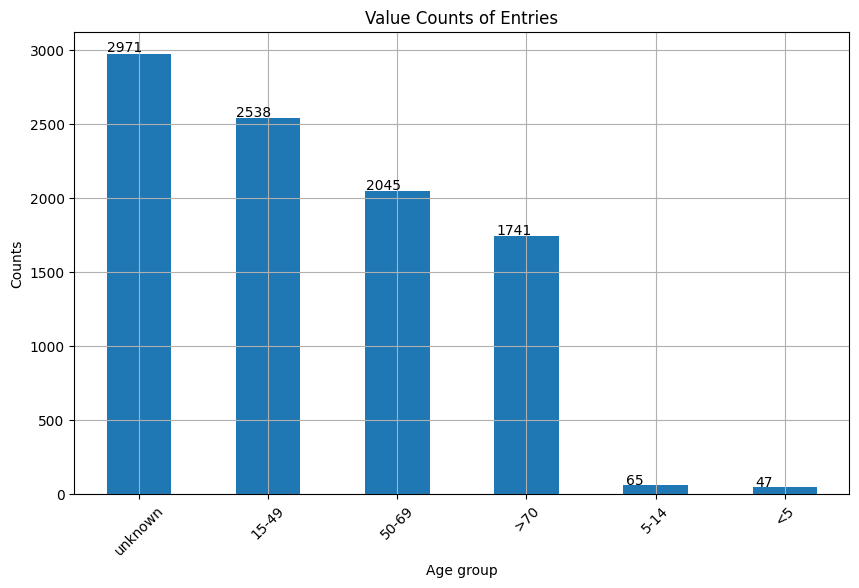

In [103]:
# Plot the bar chart
ax = df2["age_group"].value_counts().plot(kind='bar', figsize=(10, 6))
plt.grid()

# Annotate the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.xlabel('Age group')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Value Counts of Entries')
plt.show()

In [104]:
df2.columns

Index(['Virus name', 'Accession ID', 'Location', 'Collection date', 'Gender',
       'Patient age', 'Patient status', 'Specimen', 'continent', 'country',
       'state', 'city', 'status_category', 'severity_level', 'severity_num',
       'age_group'],
      dtype='object')

In [105]:
df2[df2["Collection date"] < "2020-01-01"].shape

(35, 16)

In [107]:
df2[df2["Collection date"] < "2020-01-01"].sort_values(by=["Collection date"])

,Virus name,Accession ID,Location,Collection date,Gender,Patient age,Patient status,Specimen,continent,country,state,city,status_category,severity_level,severity_num,age_group
8170,BetaCoV/bat/Yunnan/RaTG13/2013,EPI_ISL_402131,Asia / China / Yunnan / Pu’er,2013-07-24,Male,unknown,unknown,Fecal swab,Asia,China,Yunnan,Pu’er,Unknown/Missing,Unknown,NaN,unknown
8129,BetaCoV/pangolin/Guangxi/P3B/2017,EPI_ISL_410543,Asia / China / Guangxi,2017-01-01,unknown,unknown,unknown,Blood,Asia,China,Guangxi,NaN,Unknown/Missing,Unknown,NaN,unknown
8139,BetaCoV/pangolin/Guangxi/P5E/2017,EPI_ISL_410541,Asia / China / Guangxi,2017-01-01,unknown,unknown,unknown,Intestine tissue,Asia,China,Guangxi,NaN,Unknown/Missing,Unknown,NaN,unknown
8140,BetaCoV/pangolin/Guangxi/P2V/2017,EPI_ISL_410542,Asia / China / Guangxi,2017-01-01,unknown,unknown,unknown,Mixed lung and intestine tissue,Asia,China,Guangxi,NaN,Unknown/Missing,Unknown,NaN,unknown
7230,BetaCoV/pangolin/Guangxi/P5L/2017,EPI_ISL_410540,Asia / China / Guangxi,2017-01-01,unknown,unknown,unknown,Lung tissue,Asia,China,Guangxi,NaN,Unknown/Missing,Unknown,NaN,unknown
6928,BetaCoV/pangolin/Guangxi/P4L/2017,EPI_ISL_410538,Asia / China / Guangxi,2017-01-01,unknown,unknown,unknown,Lung tissue,Asia,China,Guangxi,NaN,Unknown/Missing,Unknown,NaN,unknown
8137,BetaCoV/pangolin/Guangxi/P1E/2017,EPI_ISL_410539,Asia / China / Guangxi,2017-01-01,unknown,unknown,unknown,Intestine tissue,Asia,China,Guangxi,NaN,Unknown/Missing,Unknown,NaN,unknown
8169,BetaCoV/pangolin/Guangdong/1/2019,EPI_ISL_410721,Asia / China / Guangdong,2019-01-01,unknown,>18,unknown,lung,Asia,China,Guangdong,NaN,Unknown/Missing,Unknown,NaN,15-49
8168,BetaCoV/pangolin/Guangdong/P2S/2019,EPI_ISL_410544,Asia / China / Guangdong,2019-01-01,unknown,unknown,unknown,NaN,Asia,China,Guangdong,NaN,Unknown/Missing,Unknown,NaN,unknown
8138,BetaCoV/pangolin/China/MP789/2019,EPI_ISL_412860,Asia / China,2019-03-19,unknown,unknown,unknown,Lung,Asia,China,NaN,NaN,Unknown/Missing,Unknown,NaN,unknown


In [109]:
df2.columns

Index(['Virus name', 'Accession ID', 'Location', 'Collection date', 'Gender',
       'Patient age', 'Patient status', 'Specimen', 'continent', 'country',
       'state', 'city', 'status_category', 'severity_level', 'severity_num',
       'age_group'],
      dtype='object')

In [110]:
df2["Gender"].value_counts()

Gender
Male       3582
unknown    2948
Female     2877
Name: count, dtype: int64

In [111]:
df2["status_category"].value_counts()

status_category
Unknown/Missing                      8822
Hospitalized (General)                299
Discharged/Released                   121
Mild/Recovering                        86
Hospitalized - Mild/Stable             30
Symptomatic (Unspecified)              25
Nursing Home                           13
Hospitalized - Intensive/Critical       6
Deceased                                5
Name: count, dtype: int64

In [112]:
df2["status_category"].unique()

array(['Unknown/Missing', 'Hospitalized (General)', 'Discharged/Released',
       'Mild/Recovering', 'Symptomatic (Unspecified)', 'Nursing Home',
       'Hospitalized - Mild/Stable', 'Deceased',
       'Hospitalized - Intensive/Critical'], dtype=object)